In [1]:
import torch
from minigp.gp import GaussianProcess
from minigp.kernel import RBFKernel
from minigp.acquisition import PI, EI
from minigp.optimizer import BayesianOptimizer
from minigp.utils import *

In [2]:
def black_box(X):
    return torch.sin(X)

In [3]:
def noisy_black_box(X):
    return black_box(X) + (1e-2)*torch.randn(1)

In [4]:
bounds = torch.tensor([[0,10]])
kernel = RBFKernel(0.5)
model = GaussianProcess(kernel)
acq = EI(model)
optimizer = BayesianOptimizer(black_box,model,acq,1,bounds)

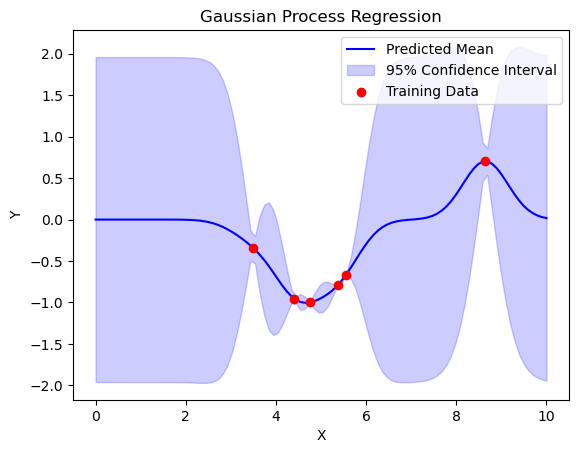

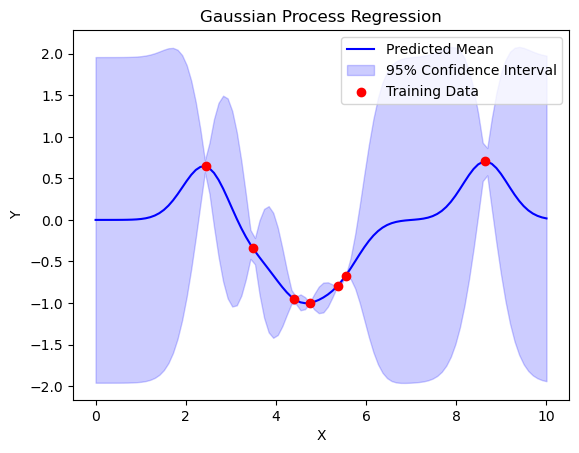

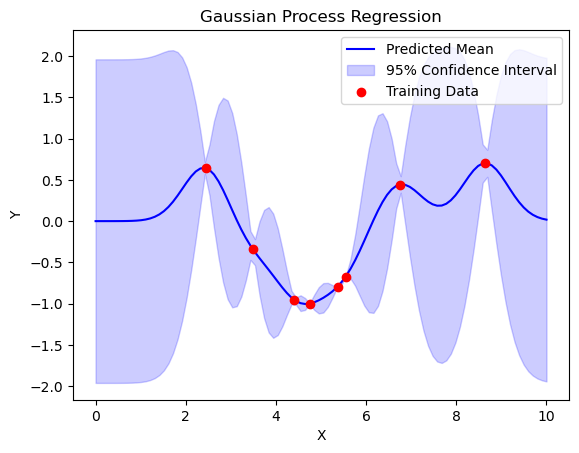

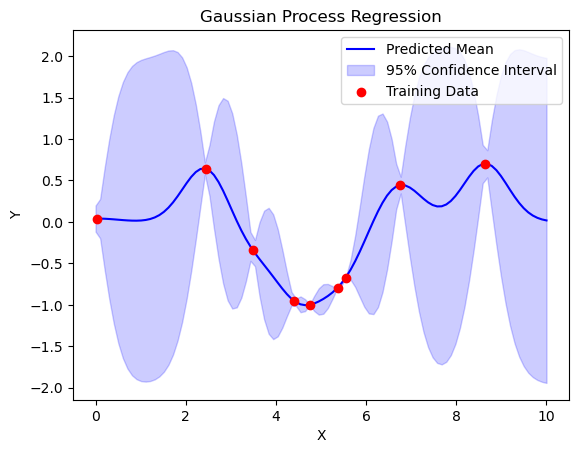

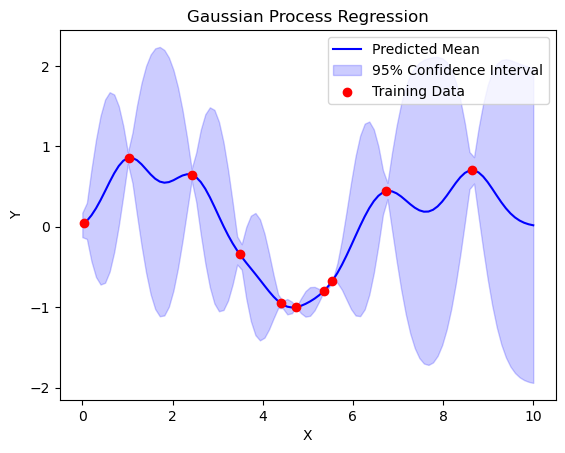

AttributeError: 'Tensor' object has no attribute 'dispatch'

In [5]:
optimizer.optimize(5,5)
print(optimizer.y_best)




# X_train = torch.rand((6, bounds.shape[0])) * (bounds[:, 1] - bounds[:, 0]) + bounds[:, 0]
# y_train = noisy_black_box(X_train)
# model.fit(X_train, y_train)
# grid = torch.linspace(0, 5, 100).unsqueeze(1)
# plot_process(model, grid)